#### Lab : Regularization and Linear models

In [31]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import (Stepwise, sklearn_selected, sklearn_selection_path)
from l0bnb import fit_path
import matplotlib.pyplot as plt

#### Subset Selection : 
- Forward
- Backward
- Mixed

### Forward Selection

_Dataset Description_

* `AtBat`: Number of times at bat in 1986
* `Hits`: Number of hits in 1986
* `HmRun`: Number of home runs in 1986
* `Runs`: Number of runs in 1986
* `RBI`: Number of runs batted in in 1986
* `Walks`: Number of walks in 1986
* `Years`: Number of years in the major leagues
* `CAtBat`: Number of times at bat during his career
* `CHits`: Number of hits during his career
* `CHmRun`: Number of home runs during his career
* `CRuns`: Number of runs during his career
* `CRBI`: Number of runs batted in during his career
* `CWalks`: Number of walks during his career
* `League`: A factor with levels A and N indicating player's league at the end of 1986
* `Division`: A factor with levels E and W indicating player's division at the end of 1986
* `PutOuts`: Number of put outs in 1986
* `Assists`: Number of assists in 1986
* `Errors`: Number of errors in 1986
* `Salary`: 1987 annual salary on opening day in thousands of dollars
* `NewLeague`: A factor with levels A and N indicating player's league at the beginning of 1987

Here probably we are going to see how the salary is influenced

In [32]:
data = load_data("Hitters")
data_new = data.dropna()
data_new.shape

(263, 20)

We are doing model selection using $C_p = \frac{\text{RSS} + 2p(\sigma^2)}{n}$ but `sklearn` doesn't define it. So we need to compute it ourselves. 

Function : 
- `sklearn_selected(model, strategy).fit(data, y)` -> Expects a scorer with just 3 arguments
- `Stepwise()` -> To specify the search strategy
- `Stepwise.first_peak(design, direction, max_terms)` -> Runs forward stepwise until forward stepwise don't result in any improvements
- `sklearn_selected_path(strategy)` : to see the path of the strategy

In [33]:
# Data Check
data = load_data("Hitters")
data.isna().sum() # There are 59 missing values in the salary.
data_new = data.dropna()
data_new.shape # 263 Entries


(263, 20)

In [34]:
def nCp(sigma, estimator, x, y): 
    n,p = x.shape
    y_hat = estimator.predict(x)
    rss = np.sum((y - y_hat)**2)
    return - (rss + 2*p*sigma) / n

def aic(estimator, x, y) : 
    return estimator.aic

# Similarly we can define the BIC and AIC

$AIC = -2ln(L) + 2p$

$BIC = -2ln(L) + ln(n)p$

In [35]:
design = MS(data_new.columns.drop("Salary")).fit(data_new)
y = data_new["Salary"]
x = design.transform(data_new)
sigma = sm.OLS(y,x).fit().scale

# Fixing the value sigma
neg_cp = partial(nCp, sigma)

# Defining Strategy
forward = Stepwise.first_peak(design, "forward", max_terms=len(design.terms))
hitters_mse = sklearn_selected(sm.OLS, forward)
hitters_mse.fit(data_new, y)
hitters_mse.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Errors',
 'Hits',
 'HmRun',
 'League',
 'NewLeague',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

`sklearn_selected()` basically fits the models using the strategy. So it transforms the variable itself, we need have `X` mentioned
- `.fit(<x>, <y>)` : to fit
- `.predict(<x>)` : to predict 

In [36]:
hitters_negcp = sklearn_selected(sm.OLS, forward,scoring=neg_cp)
hitters_negcp.fit(data_new, y)
hitters_negcp.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

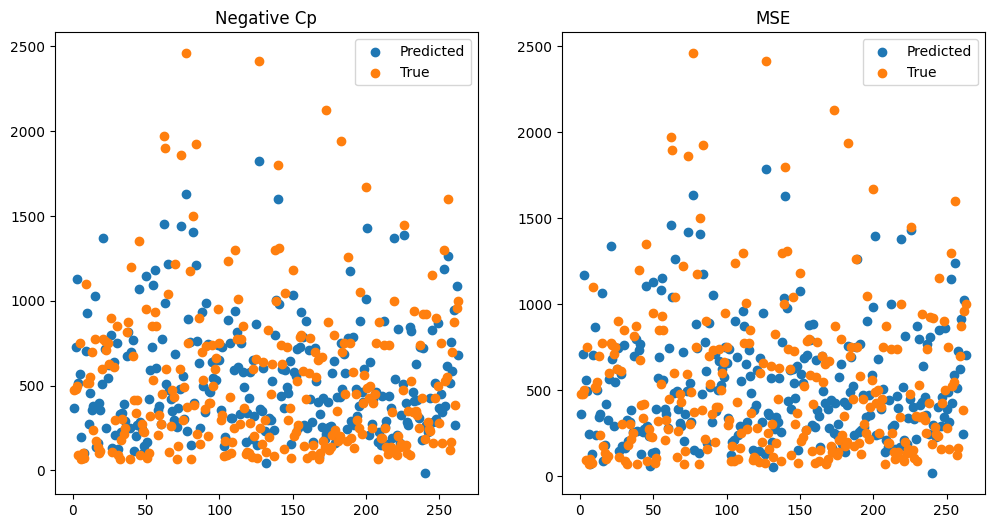

In [37]:
fig, ax = subplots(1, 2, figsize=(12, 6))
x = np.arange(1, hitters_negcp.predict(data_new).shape[0] + 1)
ax[0].scatter(x, hitters_negcp.predict(data_new), label="Predicted")
ax[1].scatter(x, hitters_mse.predict(data_new), label="Predicted")
ax[0].scatter(x, y, label="True")
ax[1].scatter(x, y, label="True")
ax[0].set_title("Negative Cp")
ax[1].set_title("MSE")
ax[0].legend()
ax[1].legend()
plt.show()

#### Model Selection Using CV , Validation Set

Model selection could be used for CV & Validation Set to calculate the error of different models and choose the model with the least error?

Validation set approach is pretty simple : You train on the training set and test on the testing set multiple times with different models and select the models with the least error.

CrossValidation : On the K - 1 you do training with different models and test on the 1, select the model with the lowest error?

`sklearn_selection_path()` -> Predicts for everypath
`cross_val_predict()` -> Computes cross validation predictions for each of the models along the path. 


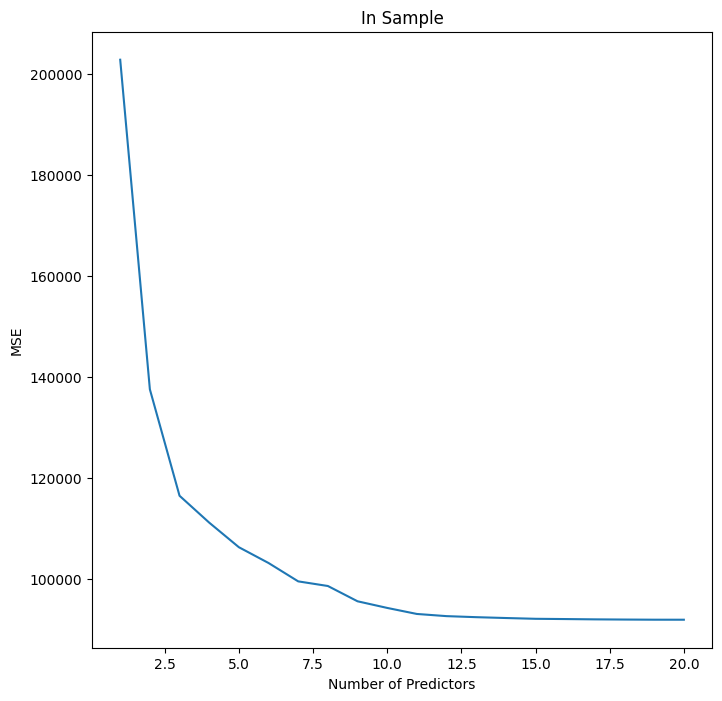

In [38]:
# Cross Validation -> C_p
strategy = Stepwise.fixed_steps(design, len(design.terms), "forward")
# strategy_back = Stepwise.fixed_steps(design, len(design.terms), "backwards")
full_path = sklearn_selection_path(sm.OLS, strategy) # Basically fits to everymodel
full_path.fit(data_new, y)

# Full Path for all the models
yhat = full_path.predict(data_new)
y = np.array(y).reshape(-1,1)
mse = ((yhat - y)**2).mean(0)
x = np.arange(1, len(mse) + 1)
fig, ax = subplots(figsize = (8,8))
ax.set_title("In Sample")
ax.set_xlabel("Number of Predictors")
ax.set_ylabel("MSE")
plt.plot(x, mse)
plt.show()

`cross_val_predict(sklearn_full_path, data, response, cv = kfold)`

In [39]:
# Cross Validation
cv = skm.KFold(5, shuffle=True, random_state=0)
yhat_cv = skm.cross_val_predict(full_path, data_new, y, cv=cv)
yhat_cv

# Basically it creates 1 hold out set, trains using full_path.fit
# Predicts using full_path.predict and concatenates the results nothing else.

array([[ 522.28257619,  590.72713282,  410.32085677, ...,  229.87272728,
         228.96840426,  230.73249093],
       [ 560.05848341,  498.60037086,  580.39175077, ...,  742.78970371,
         742.72895901,  742.76525463],
       [ 522.28257619,  930.03470602,  953.97632714, ..., 1156.30920012,
        1149.50956216, 1168.61363627],
       ...,
       [ 522.28257619,  333.84569179,  390.12799023, ...,  207.33232712,
         203.59324152,  200.14397398],
       [ 560.05848341,  619.1060376 ,  733.04854491, ..., 1047.81920062,
        1048.59251652, 1048.61193527],
       [ 522.28257619,  545.11267133,  673.81963678, ...,  609.5978068 ,
         610.99792911,  624.84722454]])

In [40]:
# A Basic Implementation of the cross_val_predict
for train_idx, test_idx in cv.split(data_new) : 
    data_train = data_new.iloc[train_idx]
    data_test = data_new.iloc[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]
    full_path.fit(data_train, y_train)
    yhat_cv = full_path.predict(data_test)
    mse = ((yhat_cv - y[test_idx])**2).mean(0)

`cross_val_predict` -> Is important function

In [43]:
cv_mse = []
for train_idx, test_idx in cv.split(y) : 
    errors = (yhat_cv[test_idx] - y[test_idx])**2
    cv_mse.append(errors.mean(0)) # Column Means
cv_mse = np.array(cv_mse).T
cv_mse.shape

# Plotting
fig, ax = subplots(figsize = (8,8))
ax.set_title("Cross Validation")
ax.set_xlabel("Number of Predictors")
ax.set_ylabel("MSE")

# Error Bars
ax.errorbar(np.arange(len(mse)), cv_mse.mean(1), cv_mse.std(1) / np.sqrt(5), label = "Cross-Validated", c = "r")
plt.show()

IndexError: index 55 is out of bounds for axis 0 with size 52

#### Ridge & Lasso

`skl.ElasticNet()` -> To do lasso and ridge regression `l1_ratio = 0`
`skl.ElasticNet.path()` -> This will give us the path and through the path we can use CV?

`Lasso` is scale dependent - we must make it scale independent first
- That is why we need to standardize and then unstandardize. 

In [44]:
import sklearn.linear_model as skl
design = MS(data_new.columns.drop("Salary")).fit(data_new)
y = data_new["Salary"]
x = design.transform(data_new)
x_cols = x.columns.drop("intercept")
x = x[x_cols]

In [45]:
# mean across columns x.mean(0)
data_cols = data_new.columns.drop("Salary")
xmean = x.mean(0) # Mean Across Columns
xstd = x.std(0)
x = (x - xmean) / xstd

lambdas = 10**np.linspace(8, -2, 100) / y.std()

# For every lambda we fit the model
ridge = skl.ElasticNet.path(x, y, l1_ratio=0, alphas=lambdas)[1]
ridge_df = pd.DataFrame(ridge.T, index = -np.log(lambdas), columns = x_cols)
ridge_df


/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64428166.064067826, tolerance: 12885.7065737425
  model = cd_fast.enet_coordinate_descent_gram(
/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regu

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League[N],Division[W],PutOuts,Assists,Errors,NewLeague[N]
-12.308950,0.000800,0.000889,0.000695,0.000851,0.000911,0.000900,0.000812,0.001067,0.001113,0.001064,0.001141,0.001149,0.000993,-0.000029,-0.000390,0.000609,0.000052,-0.000011,-0.000006
-12.076366,0.001010,0.001122,0.000878,0.001074,0.001150,0.001135,0.001025,0.001346,0.001404,0.001343,0.001439,0.001450,0.001253,-0.000037,-0.000492,0.000769,0.000065,-0.000014,-0.000007
-11.843782,0.001274,0.001416,0.001107,0.001355,0.001451,0.001433,0.001293,0.001698,0.001772,0.001694,0.001816,0.001830,0.001581,-0.000046,-0.000621,0.000970,0.000082,-0.000017,-0.000009
-11.611197,0.001608,0.001787,0.001397,0.001710,0.001831,0.001808,0.001632,0.002143,0.002236,0.002138,0.002292,0.002309,0.001995,-0.000058,-0.000784,0.001224,0.000104,-0.000022,-0.000012
-11.378613,0.002029,0.002255,0.001763,0.002158,0.002310,0.002281,0.002059,0.002704,0.002821,0.002698,0.002892,0.002914,0.002517,-0.000073,-0.000990,0.001544,0.000131,-0.000028,-0.000015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.786563,-291.377961,337.570668,37.392848,-59.860892,-26.556708,135.112619,-17.250014,-388.508857,89.749594,-12.293780,476.978230,257.755393,-213.529690,31.317828,-58.569394,78.911431,53.724135,-22.250887,-12.426638
10.019148,-291.433452,337.755101,37.501943,-60.029823,-26.656954,135.157421,-17.141448,-389.194061,89.174620,-12.682757,477.933871,258.453525,-213.686384,31.316041,-58.560353,78.911405,53.747258,-22.241196,-12.415676
10.251732,-291.477728,337.902386,37.588961,-60.164675,-26.736902,135.193142,-17.055275,-389.735199,88.709594,-12.994062,478.697241,259.011846,-213.811701,31.314559,-58.553158,78.911395,53.765538,-22.233437,-12.406879
10.484316,-291.513016,338.019836,37.658280,-60.272170,-26.800581,135.221591,-16.986903,-390.162778,88.335012,-13.242720,479.306071,259.457550,-213.911748,31.313344,-58.547437,78.911395,53.779995,-22.227235,-12.399838


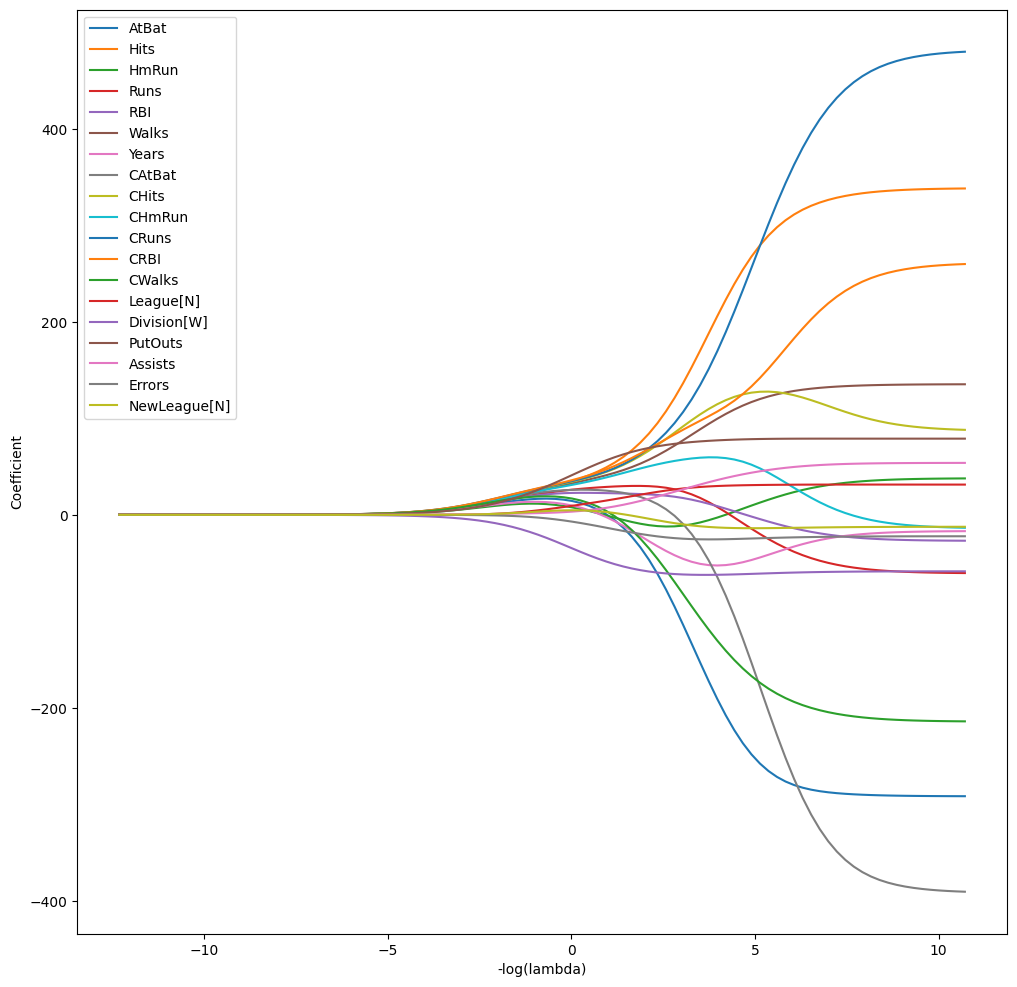

In [46]:
# How coefficients change with lambda
fig, ax = subplots(figsize = (12,12))
ridge_df.plot(ax = ax)
ax.set_xlabel("-log(lambda)")
ax.set_ylabel("Coefficient")
plt.show()

In [47]:
beta_hat = ridge_df.loc[ridge_df.index[59]]
alphaa = lambdas[59]
norm = np.linalg.norm(beta_hat)

# Ridge
ridge = skl.ElasticNet(alpha = alphaa, l1_ratio = 0)
scaler = StandardScaler(with_mean=True, with_std=True)
ridge_pipe = Pipeline([("scaler", scaler), ("ridge", ridge)])
ridge_pipe.fit(x, y)
ridge_pipe.named_steps["ridge"].coef_

/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.446e+07, tolerance: 5.332e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


array([-13.48266192,  59.9623006 ,  -5.31387273,  29.66075662,
        22.02752444,  46.27059689, -11.51584539,  22.7057135 ,
        51.65614827,  43.27434201,  52.40037999,  54.59422778,
        -8.18505813,  17.75555171, -53.476317  ,  62.52304681,
        10.40943273, -16.71569282,   0.5466619 ])

In [48]:
# Searching the best lamdba value
param_grid = {"ridge__alpha" : lambdas} # This is the grid to search from
validation = skm.ShuffleSplit(1, test_size=0.2, random_state=0)
grid = skm.GridSearchCV(ridge_pipe, param_grid, cv = validation, scoring = "neg_mean_squared_error")
grid.fit(x,y)

/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.880e+07, tolerance: 3.759e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.880e+07, tolerance: 3.759e+03 Linear regression models with null wei

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=0, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge',
                                        ElasticNet(alpha=0.24328382140679564,
                                                   l1_ratio=0))]),
             param_grid={'ridge__alpha': array([2.21671157e+05, 1.75670601e+05, 1.39215947e+05, 1.10326257e+05,
       8.74316722e+04, 6.92881050e+04, 5.49096382e+04, 4.35149493...
       4.66596538e-03, 3.69769776e-03, 2.93036224e-03, 2.32226196e-03,
       1.84035289e-03, 1.45844819e-03, 1.15579525e-03, 9.15947970e-04,
       7.25873102e-04, 5.75242020e-04, 4.55869463e-04, 3.61268754e-04,
       2.86299309e-04, 2.26887306e-04, 1.79804310e-04, 1.42491841e-04,
       1.12922347e-04, 8.94890287e-05, 7.09185249e-05, 5.62017181e-05,
       4.45389005e-05, 3.52963169e-05, 2.79717276e-05, 2.21671157e-05])},
             scoring='neg_mean_squared_error')

In [49]:
grid.best_params_["ridge__alpha"]
grid.best_estimator_

# What it does is basically
# For different lambda fit the value of ridge regression on training set and then calculate the test error and then selects the lowest test errors
# For each param_grid it evaluats ridge_pipe on the validation set.
grid = skm.GridSearchCV(ridge_pipe, param_grid, cv = skm.KFold(5, shuffle=False), scoring = "neg_mean_squared_error")
grid.fit(x,y)
grid.best_params_["ridge__alpha"]
grid.best_estimator_

/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.354e+07, tolerance: 4.708e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.803e+07, tolerance: 3.606e+03 Linear regression models with null wei

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.011829922943770218, l1_ratio=0))])

<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
/var/folders/h3/pvdfbwyx1txcx5ftyxsw_chr0000gn/T/ipykernel_78314/2477832400.py:3: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$-\log(\lambda)$')


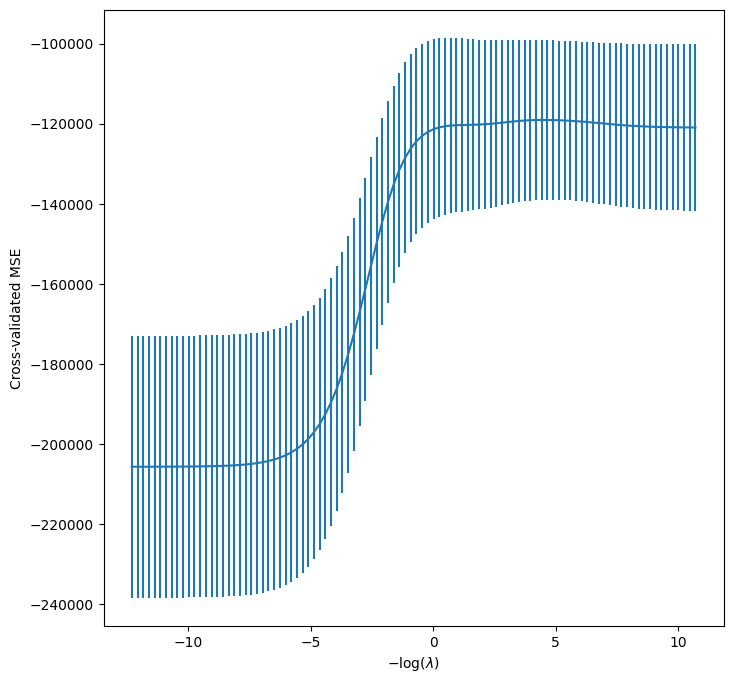

In [50]:
ridge_fig, ax = subplots(figsize = (8,8))
ax.errorbar(-np.log(lambdas), grid.cv_results_["mean_test_score"], grid.cv_results_["std_test_score"] / np.sqrt(5))
ax.set_xlabel('$-\log(\lambda)$') 
ax.set_ylabel('Cross-validated MSE')
plt.show()

`GridSearchCV(pipe, grid, cv)` -> Basically on the pipe for each grid it evaluates the on cv using the scoring criterion 

`Pipeline([step1], [step2])` -> Prevents data leakage. Need to master it

In [51]:
k = 5
ridgeCV = skl.ElasticNetCV(l1_ratio=0, alphas=lambdas, cv=skm.KFold(k, shuffle=False))
pipeCV = Pipeline([("scaler", scaler), ("ridge", ridgeCV)])
pipeCV.fit(x, y)
pipeCV.named_steps["ridge"].alpha_


/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23537641.365232278, tolerance: 4707.58808269242
  model = cd_fast.enet_coordinate_descent_gram(
/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regu

0.011829922943770218

<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
/var/folders/h3/pvdfbwyx1txcx5ftyxsw_chr0000gn/T/ipykernel_78314/130035963.py:4: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$-log(\lambda)$')


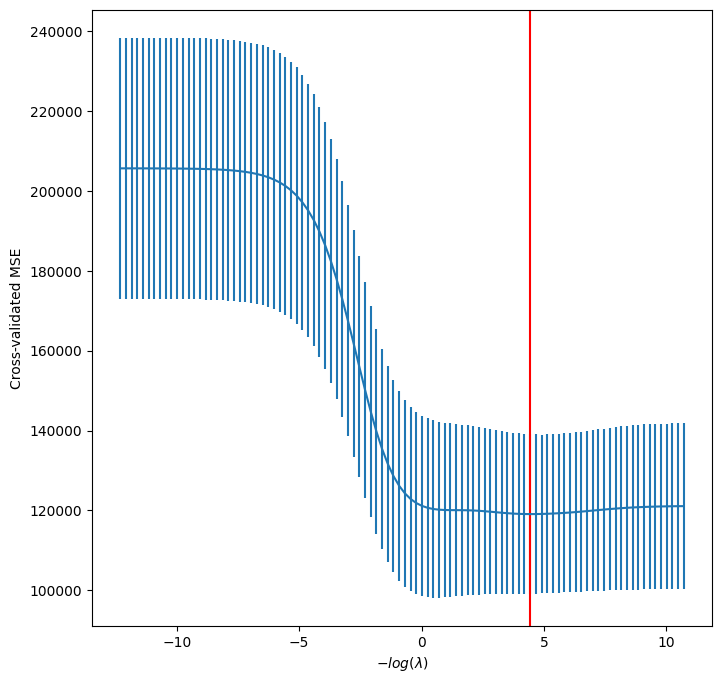

In [52]:
tuned_ridge = pipeCV.named_steps["ridge"]
fig, ax = subplots(figsize = (8,8))
ax.errorbar(-np.log(lambdas), tuned_ridge.mse_path_.mean(1), tuned_ridge.mse_path_.std(1) / np.sqrt(5))
ax.set_xlabel('$-log(\lambda)$')
ax.set_ylabel('Cross-validated MSE')
ax.axvline(-np.log(tuned_ridge.alpha_), c = "r")
plt.show()

In [53]:
ridgeCV = skl.ElasticNetCV(l1_ratio=0, alphas=lambdas, cv=skm.KFold(5, shuffle=False))
pipeCV = Pipeline([("scaler", scaler), ("ridge", ridgeCV)])
pipeCV.fit(x, y)

/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23537641.365232278, tolerance: 4707.58808269242
  model = cd_fast.enet_coordinate_descent_gram(
/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regu

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNetCV(alphas=array([2.21671157e+05, 1.75670601e+05, 1.39215947e+05, 1.10326257e+05,
       8.74316722e+04, 6.92881050e+04, 5.49096382e+04, 4.35149493e+04,
       3.44848531e+04, 2.73286563e+04, 2.16574928e+04, 1.71631927e+04,
       1.36015367e+04, 1.07789852e+04, 8.54216143e+03, 6.76951685e+03,
       5.36472633e+03, 4.25145387e+03,...
       1.84035289e-03, 1.45844819e-03, 1.15579525e-03, 9.15947970e-04,
       7.25873102e-04, 5.75242020e-04, 4.55869463e-04, 3.61268754e-04,
       2.86299309e-04, 2.26887306e-04, 1.79804310e-04, 1.42491841e-04,
       1.12922347e-04, 8.94890287e-05, 7.09185249e-05, 5.62017181e-05,
       4.45389005e-05, 3.52963169e-05, 2.79717276e-05, 2.21671157e-05]),
                              cv=KFold(n_splits=5, random_state=None, shuffle=False),
                              l1_ratio=0))])

In [61]:
# Evaluating the test error for CV Ridge
# Two Loops : One to choose \lambda and \other to evaluate the test error

# Outer loop to evaluate the test error
outer_valid = skm.ShuffleSplit(1, test_size=0.25, random_state=0)
# Inner Loop to get the best Lambda
inner_cv = skm.KFold(5, shuffle=True, random_state=0)
ridgeCV = skl.ElasticNetCV(l1_ratio=0, alphas=lambdas, cv=inner_cv)
pipeCV = Pipeline([("scaler", scaler), ("ridge", ridgeCV)])
# pipeCV.fit(x, y)
# pipeCV.named_steps["ridge"].alpha_
results = skm.cross_validate(pipeCV, x, y, cv=outer_valid, scoring="neg_mean_squared_error")
results["test_score"]

# Scaling -> Ridge -> CrossVal -> Best Alpha -> Validation -> Test Error

/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14441653.411138646, tolerance: 2888.363493206679
  model = cd_fast.enet_coordinate_descent_gram(
/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 reg

array([-129578.73586941])

In [86]:
# Lasso
lasso = skl.ElasticNetCV(l1_ratio=1, alphas=lambdas, cv=skm.KFold(5, shuffle=False))
pipeLasso = Pipeline([("scaler", scaler), ("lasso", lasso)])
pipeLasso.fit(x, y)
tuned_lasso = pipeLasso.named_steps["lasso"]

/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4298.399533106014, tolerance: 4281.420206925509
  model = cd_fast.enet_coordinate_descent_gram(
/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5924.11706648767, tolerance: 4281.420206925509
  model = cd_fast.enet_coordinate_descent_gram(
/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5205.423222923651

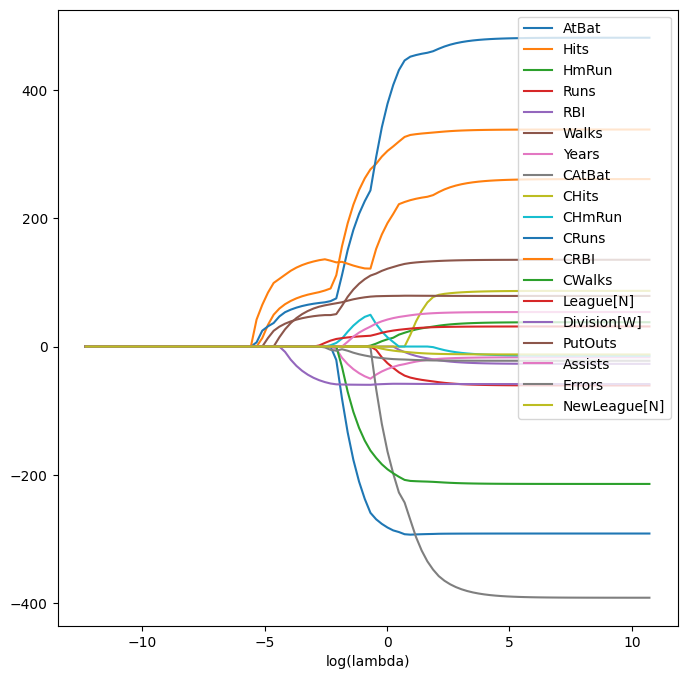

In [80]:
# Getting the lasso path
lasso_path = skl.ElasticNet.path(x, y, l1_ratio=1, alphas=lambdas)[1]
lasso_df = pd.DataFrame(lasso_path.T, index = -np.log(lambdas), columns = x_cols)
lasso_df.index.name = "log(lambda)"
lasso_df

# Plotting the lasso path
fig, ax = subplots(figsize = (8,8))
lasso_df.plot(ax = ax)
ax.legend()
plt.show()

In [93]:
print(f"Minimum Error : {np.min(tuned_lasso.mse_path_.mean(1))}")
print(f"Optimal Lambda : {tuned_lasso.alpha_}")
print(f"Coefficients : {tuned_lasso.coef_}")

Minimum Error : 119401.10427243434
Optimal Lambda : 2.4900853833599736
Coefficients : [-236.97475723  261.6857796     0.           -0.            0.
  104.82951927  -46.44607089   -0.            0.           45.62072137
  225.43632774  122.73290905 -146.04738475   16.24525248  -59.57145061
   76.62132794   26.62423765  -13.98117955   -0.        ]


Basically I have learned how to fit lasso and ridge regression here. 

Main Functions : 
1. `skl.ElasticNetCV(l1_ratio, cv, alphas)` : Basically the function helps to find out the best lambda value using cross validation
2. `Pipeline([])` : To standardize the whole pre processing and fitting steps, we use it with scaler and ridgeCV defined above
3. `skl.ElasticNet.path(x, y, l1_ratio = 1, cv)` : To get the path of the ridge / lasso regression : we transform it using the `pd.DataFrame` with index as `alphas` to visualize the path
4. `GridSearchCV()` with grid param to search for the best alpha, with the increasing parameters it becomes infeasible

### PCR & PLS Regression
- `PCA()` from `sklearn.decomposition` to do principal component analysis
- `skl.LinearRegression()` to fit the linear regression

In [103]:
data = load_data("Hitters")
data = data.dropna()
x = MS(data.columns.drop("Salary")).fit_transform(data)
x_new = x.drop("intercept", axis=1)
y = data["Salary"]

In [108]:
pca = PCA(n_components=2)
linreg = skl.LinearRegression()
pipe = Pipeline([("scaler", StandardScaler()), ("pca", pca), ("linreg", linreg)])
pipe

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=2)),
                ('linreg', LinearRegression())])

In [109]:
pipe.fit(x_new, y)
pipe.named_steps["linreg"].coef_

array([106.36859204,  21.60350456])

In [ ]:
# Grid Search for best number of components
param_grid = {"pca__n_components" : range(1,20)}
grid = skm.GridSearchCV(pipe, param_grid, cv = skm.KFold(5, shuffle=False), scoring = "neg_mean_squared_error")
grid.fit(x_new, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])},
             scoring='neg_mean_squared_error')

In [114]:
 # 18 Components works well
grid.best_params_

{'pca__n_components': 18}

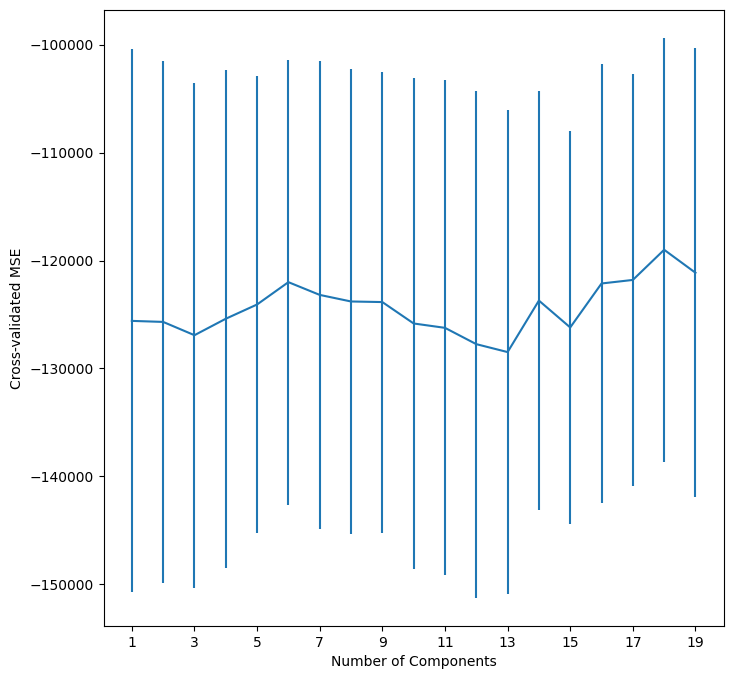

In [118]:
pcr_fig, ax = subplots(figsize = (8,8))
ncomp = param_grid["pca__n_components"]
ax.errorbar(ncomp, grid.cv_results_["mean_test_score"], grid.cv_results_["std_test_score"] / np.sqrt(5))
ax.set_xlabel("Number of Components")
ax.set_ylabel("Cross-validated MSE")
ax.set_xticks(ncomp[::2])
plt.show()

In [131]:
# Fitting with null models 
# PCA complains if we try to fit with 0 components
n = np.zeros((x.shape[0], 1))
cv_null = skm.cross_val_score(linreg, n, y, cv=skm.KFold(5, shuffle=False), scoring="neg_mean_squared_error")
cv_null.mean()

-205647.1703998647

`grid.bestEsimator()`

In [137]:
# Some Explanations
pipe.named_steps["pca"].explained_variance_ratio_.sum()
# 60% of the variance is explained by two components

0.60155315411547

In [143]:
# PLS Regression
pls = PLSRegression(n_components=2,scale=True)
pls.fit(x_new, y)

PLSRegression()

In [145]:

param_grid = {"pls__n_components" : range(1,20)}
pipe = Pipeline([("scaler", StandardScaler()), ("pls", pls)])
grid = skm.GridSearchCV(pipe, param_grid, cv = skm.KFold(5, shuffle=False), scoring = "neg_mean_squared_error")
grid.fit(x_new, y)

# 15 Components is the best component

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pls', PLSRegression())]),
             param_grid={'pls__n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

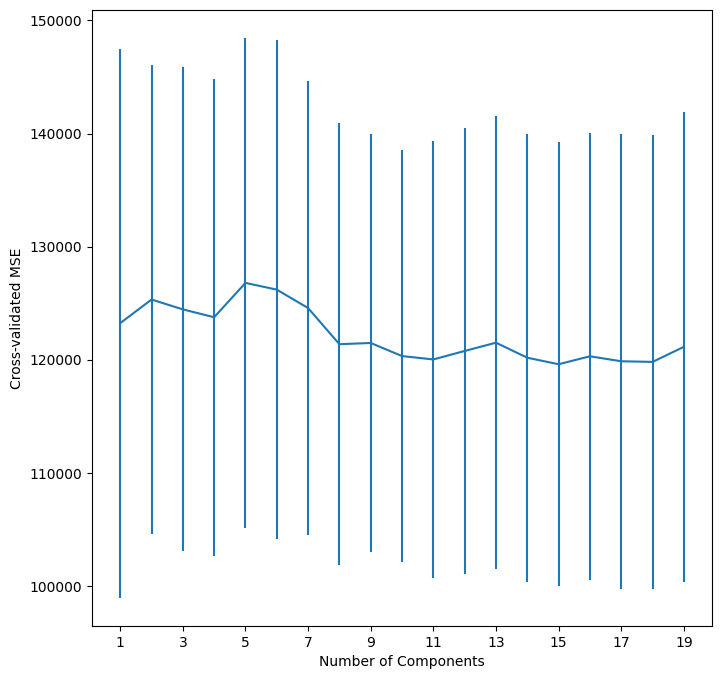

14

In [159]:
pls_fig, ax = subplots(figsize = (8,8))
ncomp = param_grid["pls__n_components"]
ax.errorbar(ncomp, -grid.cv_results_["mean_test_score"], grid.cv_results_["std_test_score"] / np.sqrt(5))
ax.set_xlabel("Number of Components")
ax.set_ylabel("Cross-validated MSE")
ax.set_xticks(ncomp[::2])
plt.show()

# These functions can be used to calculate the loc of the grid.
np.argmax(grid.cv_results_["mean_test_score"])